# 基于XGBoost的飞机发动机损坏传播建模

本notebook专注于使用XGBoost算法对NASA C-MAPS数据集中的飞机发动机数据进行预测性维护建模。主要包含两个部分：
1. **回归任务**：预测发动机的剩余使用寿命（RUL）
2. **分类任务**：判断发动机是否在10个周期内需要维护

### 参考数据集来源
- NASA C-MAPS Turbofan Engine Degradation Simulation Data Set
- [Data Source](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan)

In [1]:
# 导入所需的库
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm

# 设置图形显示参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
rcParams['figure.figsize'] = 10, 8

# 设置随机种子以确保结果可重现
np.random.seed(1234)  
PYTHONHASHSEED = 0

print("所有库导入成功！")
print(f"pandas版本: {pd.__version__}")
print(f"numpy版本: {np.__version__}")
print(f"scikit-learn版本: {sklearn.__version__}")
print(f"xgboost版本: {xgboost.__version__}")

所有库导入成功！
pandas版本: 2.3.3
numpy版本: 1.23.5
scikit-learn版本: 1.7.2
xgboost版本: 3.1.1


## 1. 数据加载与初步探索

In [2]:
# 加载训练数据
print("正在加载训练数据...")
fd_001_train = pd.read_csv("./CMaps/train_FD001.txt", sep=" ", header=None)
print(f"训练数据形状: {fd_001_train.shape}")

# 加载测试数据
print("正在加载测试数据...")
fd_001_test = pd.read_csv("./CMaps/test_FD001.txt", sep=" ", header=None)
print(f"测试数据形状: {fd_001_test.shape}")

print("\n数据加载完成！")

正在加载训练数据...
训练数据形状: (20631, 28)
正在加载测试数据...
测试数据形状: (13096, 28)

数据加载完成！


In [4]:
# 查看训练数据的基本信息
print("=== 训练数据基本信息 ===")
print(f"数据形状: {fd_001_train.shape}")
print(f"列数: {fd_001_train.shape[1]}")
print(f"行数: {fd_001_train.shape[0]}")
print("\n数据类型:")
print(fd_001_train.dtypes)
print("\n缺失值统计:")
print(fd_001_train.isnull().sum())

=== 训练数据基本信息 ===
数据形状: (20631, 28)
列数: 28
行数: 20631

数据类型:
0       int64
1       int64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21      int64
22      int64
23    float64
24    float64
25    float64
26    float64
27    float64
dtype: object

缺失值统计:
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    20631
27    20631
dtype: int64


In [5]:
# 查看训练数据的前几行和后几行
print("训练数据前5行:")
display(fd_001_train.head())

print("\n训练数据后5行:")
display(fd_001_train.tail())

训练数据前5行:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN



训练数据后5行:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,NaN,NaN


In [ ]:
# 查看训练数据的统计描述
print("训练数据统计描述:")
display(fd_001_train.describe())

In [6]:
# 检查数据中的唯一值
print("各列的唯一值数量:")
for col in fd_001_train.columns:
    unique_count = fd_001_train[col].nunique()
    print(f"列 {col}: {unique_count} 个唯一值")
    
    # 如果唯一值很少，显示具体值
    if unique_count <= 10:
        print(f"  唯一值: {sorted(fd_001_train[col].unique())}")
    print()

各列的唯一值数量:
列 0: 100 个唯一值

列 1: 362 个唯一值

列 2: 158 个唯一值

列 3: 13 个唯一值

列 4: 1 个唯一值
  唯一值: [100.0]

列 5: 1 个唯一值
  唯一值: [518.67]

列 6: 310 个唯一值

列 7: 3012 个唯一值

列 8: 4051 个唯一值

列 9: 1 个唯一值
  唯一值: [14.62]

列 10: 2 个唯一值
  唯一值: [21.6, 21.61]

列 11: 513 个唯一值

列 12: 53 个唯一值

列 13: 6403 个唯一值

列 14: 1 个唯一值
  唯一值: [1.3]

列 15: 159 个唯一值

列 16: 427 个唯一值

列 17: 56 个唯一值

列 18: 6078 个唯一值

列 19: 1918 个唯一值

列 20: 1 个唯一值
  唯一值: [0.03]

列 21: 13 个唯一值

列 22: 1 个唯一值
  唯一值: [2388]

列 23: 1 个唯一值
  唯一值: [100.0]

列 24: 120 个唯一值

列 25: 4745 个唯一值

列 26: 0 个唯一值
  唯一值: [nan]

列 27: 0 个唯一值
  唯一值: [nan]



### 数据清洗

In [7]:
# 删除空列（第26和27列）
print("删除前的列数:", fd_001_train.shape[1])
fd_001_train.drop(columns=[26,27], inplace=True)
fd_001_test.drop(columns=[26,27], inplace=True)
print("删除后的列数:", fd_001_train.shape[1])
print("空列删除完成！")

删除前的列数: 28
删除后的列数: 26
空列删除完成！


In [8]:
# 定义列名
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

print(f"列名数量: {len(columns)}")
print(f"数据列数: {fd_001_train.shape[1]}")

# 为数据设置列名
fd_001_train.columns = columns
fd_001_test.columns = columns

print("列名设置完成！")
print("\n设置列名后的训练数据:")
display(fd_001_train.head())

列名数量: 26
数据列数: 26
列名设置完成！

设置列名后的训练数据:


,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [9]:
# 查看设置列名后的数据统计信息
print("设置列名后的数据统计:")
display(fd_001_train.describe())

设置列名后的数据统计:


,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


### 删除常数列

In [10]:
# 识别常数列（标准差为0的列）
constant_columns = []
for col in fd_001_train.columns:
    if fd_001_train[col].std() == 0:
        constant_columns.append(col)

print(f"识别到的常数列: {constant_columns}")
print(f"常数列数量: {len(constant_columns)}")

识别到的常数列: ['TRA', 'T2', 'epr', 'Nf_dmd', 'PCNfR_dmd']
常数列数量: 5


In [11]:
# 删除常数列，这些列不包含关于发动机状态的信息
columns_to_drop = ['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr']
print(f"要删除的列: {columns_to_drop}")

print(f"\n删除前的训练数据形状: {fd_001_train.shape}")
print(f"删除前的测试数据形状: {fd_001_test.shape}")

fd_001_train.drop(columns=columns_to_drop, inplace=True)
fd_001_test.drop(columns=columns_to_drop, inplace=True)

print(f"\n删除后的训练数据形状: {fd_001_train.shape}")
print(f"删除后的测试数据形状: {fd_001_test.shape}")
print("常数列删除完成！")

要删除的列: ['Nf_dmd', 'PCNfR_dmd', 'P2', 'T2', 'TRA', 'farB', 'epr']

删除前的训练数据形状: (20631, 26)
删除前的测试数据形状: (13096, 26)

删除后的训练数据形状: (20631, 19)
删除后的测试数据形状: (13096, 19)
常数列删除完成！


In [12]:
# 查看删除常数列后的数据
print("删除常数列后的数据列:")
print(fd_001_train.columns.tolist())
print(f"\n剩余列数: {len(fd_001_train.columns)}")

删除常数列后的数据列:
['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']

剩余列数: 19


### 探索发动机数据分布

In [13]:
# 查看发动机数量和每个发动机的数据点
num_engines_train = fd_001_train['unit_number'].nunique()
num_engines_test = fd_001_test['unit_number'].nunique()

print(f"训练数据中的发动机数量: {num_engines_train}")
print(f"测试数据中的发动机数量: {num_engines_test}")

# 查看每个发动机的数据点数量
train_cycles = fd_001_train.groupby('unit_number')['time_in_cycles'].max()
test_cycles = fd_001_test.groupby('unit_number')['time_in_cycles'].max()

print(f"\n训练数据中每个发动机的周期统计:")
print(f"平均周期数: {train_cycles.mean():.1f}")
print(f"最小周期数: {train_cycles.min()}")
print(f"最大周期数: {train_cycles.max()}")

print(f"\n测试数据中每个发动机的周期统计:")
print(f"平均周期数: {test_cycles.mean():.1f}")
print(f"最小周期数: {test_cycles.min()}")
print(f"最大周期数: {test_cycles.max()}")

训练数据中的发动机数量: 100
测试数据中的发动机数量: 100

训练数据中每个发动机的周期统计:
平均周期数: 206.3
最小周期数: 128
最大周期数: 362

测试数据中每个发动机的周期统计:
平均周期数: 131.0
最小周期数: 31
最大周期数: 303


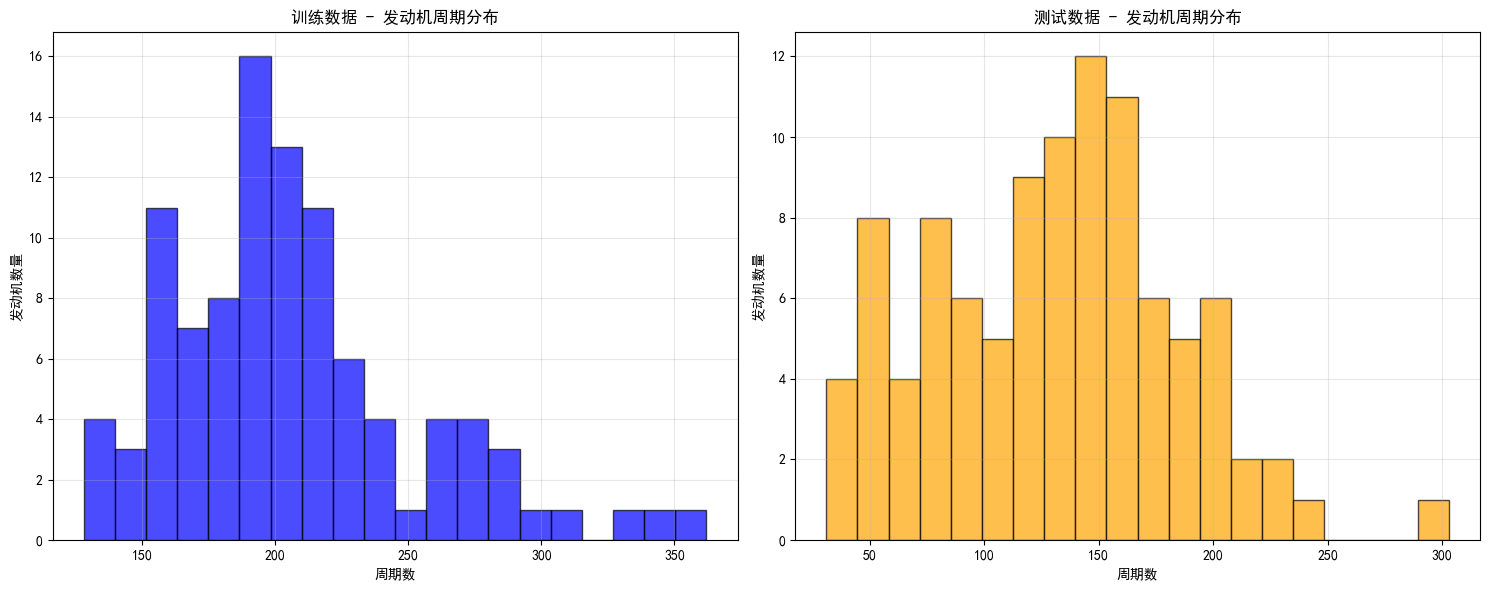

In [14]:
# 可视化发动机周期分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 训练数据周期分布
ax1.hist(train_cycles, bins=20, alpha=0.7, color='blue', edgecolor='black')
ax1.set_title('训练数据 - 发动机周期分布')
ax1.set_xlabel('周期数')
ax1.set_ylabel('发动机数量')
ax1.grid(True, alpha=0.3)

# 测试数据周期分布
ax2.hist(test_cycles, bins=20, alpha=0.7, color='orange', edgecolor='black')
ax2.set_title('测试数据 - 发动机周期分布')
ax2.set_xlabel('周期数')
ax2.set_ylabel('发动机数量')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 创建RUL（剩余使用寿命）目标变量

In [16]:
# 准备训练数据并形成RUL列，包含距离故障的剩余周期数
def prepare_train_data(data, factor=0):
    """
    准备训练数据并计算RUL
    
    参数:
    - data: 原始数据
    - factor: 要排除的早期周期数
    
    返回:
    - 包含RUL列的数据框
    """
    df = data.copy()
    
    # 计算每个发动机的最大周期数
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    
    # 合并最大周期数到原始数据
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    
    # 计算RUL = 最大周期数 - 当前周期数
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'], inplace=True)
    
    # 只保留大于factor的周期
    return df[df['time_in_cycles'] > factor]

# 准备训练数据
print("正在准备训练数据...")
df = prepare_train_data(fd_001_train)
print(f"准备后的训练数据形状: {df.shape}")
print("训练数据准备完成！")

正在准备训练数据...
准备后的训练数据形状: (20631, 20)
训练数据准备完成！


In [17]:
# 查看添加RUL后的数据
print("添加RUL后的数据样本:")
display(df.head())

print("\nRUL统计信息:")
print(df['RUL'].describe())

print("\nRUL分布:")
print(f"最小RUL: {df['RUL'].min()}")
print(f"最大RUL: {df['RUL'].max()}")
print(f"平均RUL: {df['RUL'].mean():.1f}")

添加RUL后的数据样本:


,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187



RUL统计信息:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

RUL分布:
最小RUL: 0
最大RUL: 361
平均RUL: 107.8


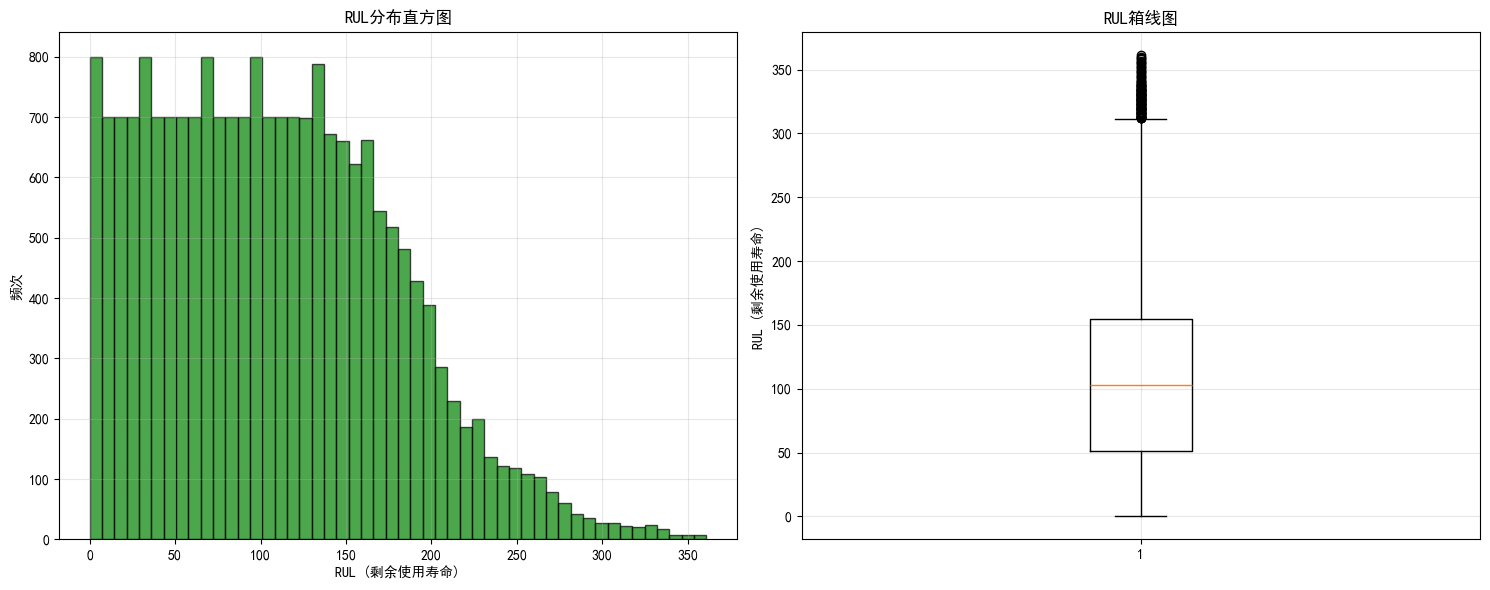

In [18]:
# 可视化RUL分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RUL分布直方图
ax1.hist(df['RUL'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax1.set_title('RUL分布直方图')
ax1.set_xlabel('RUL (剩余使用寿命)')
ax1.set_ylabel('频次')
ax1.grid(True, alpha=0.3)

# RUL箱线图
ax2.boxplot(df['RUL'])
ax2.set_title('RUL箱线图')
ax2.set_ylabel('RUL (剩余使用寿命)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 特征相关性分析

In [19]:
# 计算特征相关性矩阵
print("正在计算特征相关性矩阵...")
correlation_matrix = df.corr()

print(f"相关性矩阵形状: {correlation_matrix.shape}")
print("\n与RUL的相关性:")
rul_correlation = correlation_matrix['RUL'].sort_values(ascending=False)
print(rul_correlation)

正在计算特征相关性矩阵...
相关性矩阵形状: (20, 20)

与RUL的相关性:
RUL               1.000000
phi               0.671983
P30               0.657223
W32               0.635662
W31               0.629428
unit_number       0.078753
setting_2        -0.001948
setting_1        -0.003198
P15              -0.128348
NRc              -0.306769
Nc               -0.390102
NRf              -0.562569
Nf               -0.563968
T30              -0.584520
htBleed          -0.606154
T24              -0.606484
BPR              -0.642667
T50              -0.678948
Ps30             -0.696228
time_in_cycles   -0.736241
Name: RUL, dtype: float64


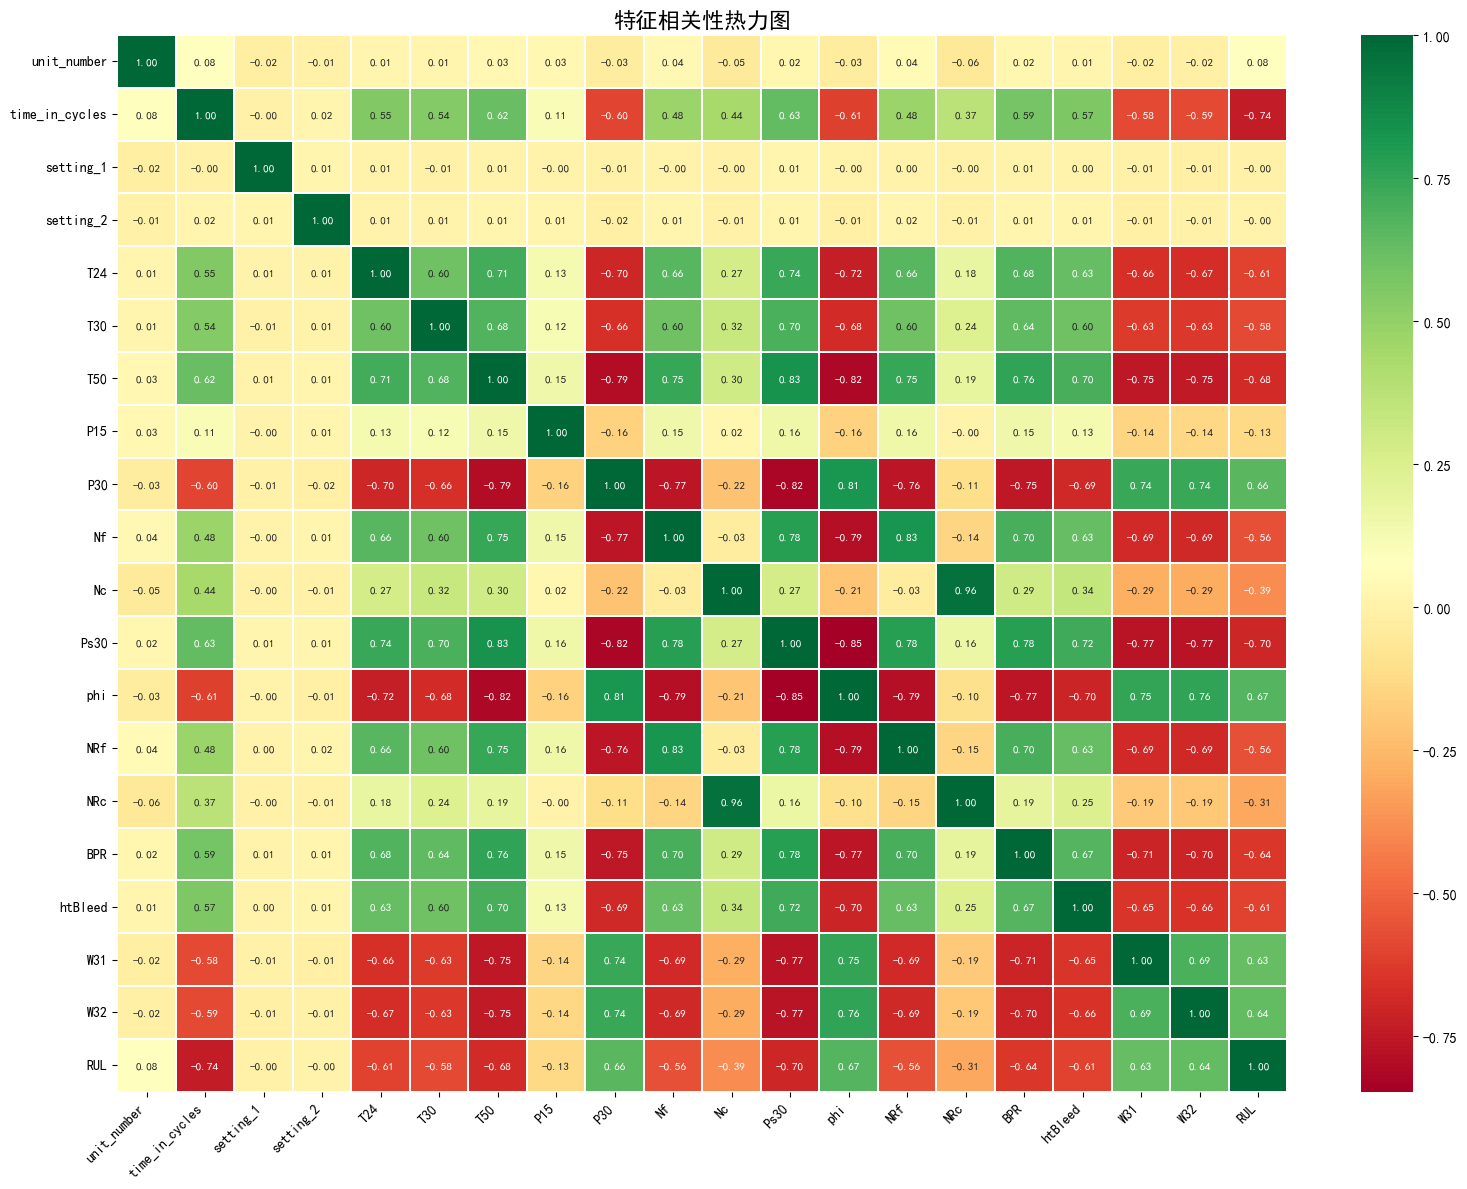

In [20]:
# 绘制特征相关性热力图
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdYlGn', 
            linewidths=0.2,
            fmt='.2f',
            annot_kws={'size': 8})
plt.title('特征相关性热力图', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
# 找出与RUL相关性最高的特征
print("与RUL相关性最高的特征 (绝对值):")
rul_corr_abs = abs(correlation_matrix['RUL']).sort_values(ascending=False)
print(rul_corr_abs[1:11])  # 排除RUL自身

与RUL相关性最高的特征 (绝对值):
time_in_cycles    0.736241
Ps30              0.696228
T50               0.678948
phi               0.671983
P30               0.657223
BPR               0.642667
W32               0.635662
W31               0.629428
T24               0.606484
htBleed           0.606154
Name: RUL, dtype: float64


### 识别高度相关的特征对

In [22]:
# 找出高度相关的特征对 (相关系数 > 0.8 或 < -0.8)
high_corr_pairs = []
threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr_value
            })

print(f"高度相关的特征对 (阈值: {threshold}):")
for pair in high_corr_pairs:
    print(f"{pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.3f}")

print(f"\n总共找到 {len(high_corr_pairs)} 对高度相关的特征")

高度相关的特征对 (阈值: 0.8):
T50 <-> Ps30: 0.830
T50 <-> phi: -0.816
P30 <-> Ps30: -0.823
P30 <-> phi: 0.813
Nf <-> NRf: 0.826
Nc <-> NRc: 0.963
Ps30 <-> phi: -0.847

总共找到 7 对高度相关的特征


### 特征选择

基于相关性分析，我们将：
1. 删除与RUL弱相关的特征：setting_1, setting_2, P15, unit_number
2. 删除高度相关的特征之一：Nc和NRc的相关系数为0.96，删除NRc

In [23]:
# 保存unit_number供后续使用
unit_number = pd.DataFrame(df["unit_number"])

# 删除不重要的特征
features_to_drop = ['unit_number', 'setting_1', 'setting_2', 'P15', 'NRc']
print(f"要删除的特征: {features_to_drop}")

print(f"\n删除前的特征数量: {len(df.columns)}")
train_df = df.drop(columns=features_to_drop)
print(f"删除后的特征数量: {len(train_df.columns)}")

print("\n最终保留的特征:")
print(train_df.columns.tolist())

要删除的特征: ['unit_number', 'setting_1', 'setting_2', 'P15', 'NRc']

删除前的特征数量: 20
删除后的特征数量: 15

最终保留的特征:
['time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'RUL']


In [24]:
# 查看处理后的训练数据
print("处理后的训练数据样本:")
display(train_df.head())

print("\n处理后的数据统计:")
display(train_df.describe())

print(f"\n最终数据形状: {train_df.shape}")
print(f"特征数量: {train_df.shape[1] - 1}")  # 减去RUL列

处理后的训练数据样本:


,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187



处理后的数据统计:


,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,108.807862,642.680934,1590.523119,1408.933782,553.367711,2388.096652,9065.242941,47.541168,521.413470,2388.096152,8.442146,393.210654,38.816271,23.289705,107.807862
std,68.880990,0.500053,6.131150,9.000605,0.885092,0.070985,22.082880,0.267087,0.737553,0.071919,0.037505,1.548763,0.180746,0.108251,68.880990
min,1.000000,641.210000,1571.040000,1382.250000,549.850000,2387.900000,9021.730000,46.850000,518.690000,2387.880000,8.324900,388.000000,38.140000,22.894200,0.000000
25%,52.000000,642.325000,1586.260000,1402.360000,552.810000,2388.050000,9053.100000,47.350000,520.960000,2388.040000,8.414900,392.000000,38.700000,23.221800,51.000000
50%,104.000000,642.640000,1590.100000,1408.040000,553.440000,2388.090000,9060.660000,47.510000,521.480000,2388.090000,8.438900,393.000000,38.830000,23.297900,103.000000
75%,156.000000,643.000000,1594.380000,1414.555000,554.010000,2388.140000,9069.420000,47.700000,521.950000,2388.140000,8.465600,394.000000,38.950000,23.366800,155.000000
max,362.000000,644.530000,1616.910000,1441.490000,556.060000,2388.560000,9244.590000,48.530000,523.380000,2388.560000,8.584800,400.000000,39.430000,23.618400,361.000000



最终数据形状: (20631, 15)
特征数量: 14


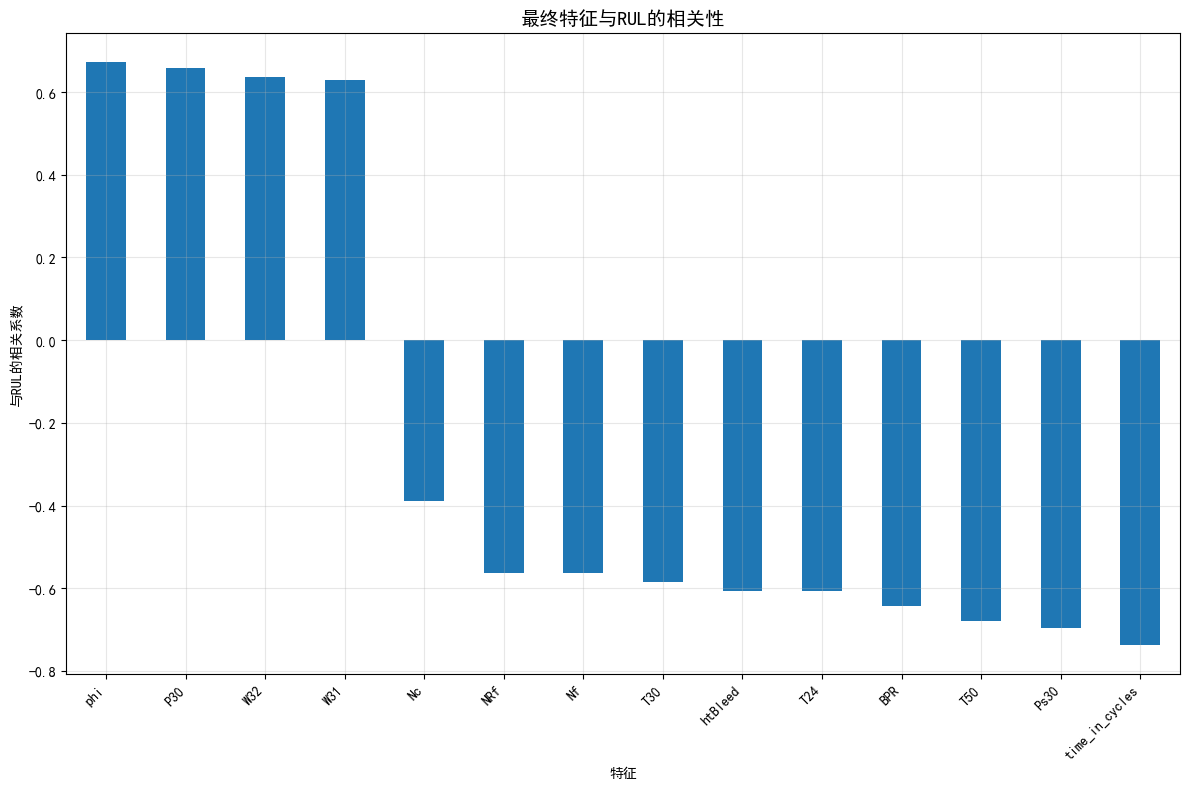

最终特征与RUL的相关性:
phi: 0.672
P30: 0.657
W32: 0.636
W31: 0.629
Nc: -0.390
NRf: -0.563
Nf: -0.564
T30: -0.585
htBleed: -0.606
T24: -0.606
BPR: -0.643
T50: -0.679
Ps30: -0.696
time_in_cycles: -0.736


In [25]:
# 可视化最终特征与RUL的相关性
final_features = train_df.drop('RUL', axis=1).columns
final_correlations = train_df[final_features].corrwith(train_df['RUL']).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
final_correlations.plot(kind='bar')
plt.title('最终特征与RUL的相关性', fontsize=14)
plt.xlabel('特征')
plt.ylabel('与RUL的相关系数')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("最终特征与RUL的相关性:")
for feature, corr in final_correlations.items():
    print(f"{feature}: {corr:.3f}")

## 2. XGBoost回归模型 - RUL预测

### 评估指标定义

In [ ]:
# 竞赛数据的误差函数
def score(y_true, y_pred, a1=10, a2=13):
    """
    竞赛的评分函数
    
    参数:
    - y_true: 真实值
    - y_pred: 预测值
    - a1: 提前预测的惩罚参数 (默认10)
    - a2: 延迟预测的惩罚参数 (默认13)
    """
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0:
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

# 评估函数：计算多个指标
def score_func(y_true, y_pred):
    """
    计算并显示多个评估指标
    """
    lst = [round(score(y_true, y_pred), 2), 
          round(mean_absolute_error(y_true, y_pred), 2),
          round(mean_squared_error(y_true, y_pred), 2)**0.5,
          round(r2_score(y_true, y_pred), 2)]
    
    print(f'竞赛评分: {lst[0]}')
    print(f'平均绝对误差 (MAE): {lst[1]}')
    print(f'均方根误差 (RMSE): {lst[2]}')
    print(f'R²分数: {lst[3]}')
    return [lst[1], round(lst[2], 2), lst[3]*100]

print("评估函数定义完成！")

评估函数定义完成！


### 测试数据准备

In [27]:
# 为测试数据添加最大周期信息
print("准备测试数据...")
test_max = fd_001_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number','max']

fd_001_test = fd_001_test.merge(test_max, on=['unit_number'], how='left')

# 提取每台发动机的最后一个数据点
test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max']].reset_index()
test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'], inplace=True)

X_001_test = test.to_numpy()
print(f"测试数据形状: {X_001_test.shape}")
print(f"测试数据特征数量: {X_001_test.shape[1]}")
print("测试数据准备完成！")

准备测试数据...
测试数据形状: (100, 14)
测试数据特征数量: 14
测试数据准备完成！


In [28]:
# 查看测试数据
print("测试数据样本:")
test_df = pd.DataFrame(X_001_test, columns=train_df.drop('RUL', axis=1).columns)
display(test_df.head())

print("\n测试数据统计:")
display(test_df.describe())

测试数据样本:


,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32
0,31.0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8.4024,393.0,38.81,23.3552
1,49.0,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8.4505,391.0,38.81,23.2618
2,126.0,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8.4119,395.0,38.93,23.2740
3,106.0,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8.4634,395.0,38.58,23.2581
4,98.0,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8.4362,394.0,38.75,23.4117



测试数据统计:


,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.0000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,130.960000,642.768400,1591.824700,1410.548200,553.148900,2388.1191,9063.703400,47.595100,521.277000,2388.11730,8.452841,393.520000,38.764800,23.259711
std,53.593479,0.444592,6.646293,8.626344,0.880291,0.0647,21.993046,0.256989,0.697532,0.06837,0.032964,1.466667,0.155962,0.096530
min,31.000000,641.750000,1576.930000,1389.330000,550.880000,2387.9900,9026.890000,47.080000,519.440000,2387.96000,8.373200,390.000000,38.350000,23.024200
25%,88.750000,642.490000,1587.007500,1403.912500,552.577500,2388.0800,9051.295000,47.397500,520.812500,2388.07000,8.431200,392.750000,38.637500,23.192700
50%,133.500000,642.775000,1591.365000,1410.300000,553.270000,2388.1100,9057.645000,47.585000,521.450000,2388.11000,8.450250,393.000000,38.775000,23.275550
75%,164.250000,643.025000,1597.280000,1416.922500,553.735000,2388.1600,9070.022500,47.757500,521.772500,2388.16000,8.472050,394.250000,38.890000,23.311100
max,303.000000,644.030000,1607.550000,1428.420000,555.070000,2388.2900,9155.030000,48.130000,522.650000,2388.29000,8.525900,397.000000,39.190000,23.498200


### XGBoost模型训练函数

In [29]:
# 创建和训练XGBoost回归模型的函数
def train_xgboost_model(data, n_estimators=110, learning_rate=0.018, max_depth=3):
    """
    训练XGBoost回归模型
    
    参数:
    - data: 训练数据
    - n_estimators: 树的数量
    - learning_rate: 学习率
    - max_depth: 树的最大深度
    
    返回:
    - 训练好的XGBoost模型
    """
    X = data.iloc[:, :14].to_numpy() 
    Y = data.iloc[:, 14:].to_numpy()
    Y = np.ravel(Y)
    
    print(f"特征矩阵形状: {X.shape}")
    print(f"目标向量形状: {Y.shape}")
    print(f"特征数量: {X.shape[1]}")
    print(f"样本数量: {X.shape[0]}")
    
    # XGBoost回归器
    model = xgboost.XGBRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        gamma=0, 
        subsample=0.8,
        colsample_bytree=0.5, 
        max_depth=max_depth,
        random_state=42
    )
    
    print("\n开始训练XGBoost模型...")
    model.fit(X, Y)
    print("模型训练完成！")
    
    return model

print("XGBoost训练函数定义完成！")

XGBoost训练函数定义完成！


### 基础XGBoost模型训练

In [30]:
# 训练基础XGBoost模型
print("=== 训练基础XGBoost模型 ===")
xgb_model = train_xgboost_model(train_df)

=== 训练基础XGBoost模型 ===
特征矩阵形状: (20631, 14)
目标向量形状: (20631,)
特征数量: 14
样本数量: 20631

开始训练XGBoost模型...
模型训练完成！


特征重要性:
           feature  importance
0   time_in_cycles    0.202436
3              T50    0.188895
7             Ps30    0.187163
8              phi    0.114186
4              P30    0.069632
12             W31    0.059214
6               Nc    0.045378
10             BPR    0.034032
13             W32    0.028862
1              T24    0.027393
5               Nf    0.017350
11         htBleed    0.015029
2              T30    0.008052
9              NRf    0.002375


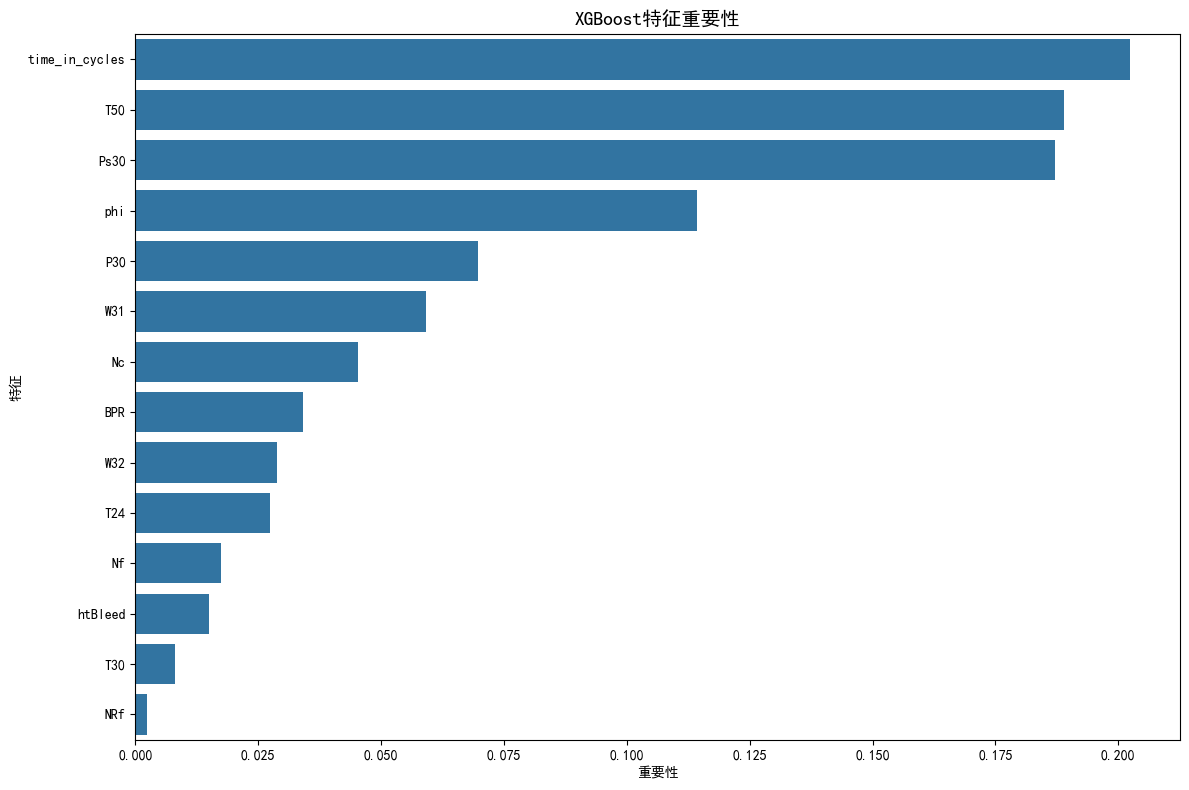

In [31]:
# 查看模型特征重要性
feature_names = train_df.drop('RUL', axis=1).columns
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("特征重要性:")
print(feature_importance)

# 可视化特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('XGBoost特征重要性', fontsize=14)
plt.xlabel('重要性')
plt.ylabel('特征')
plt.tight_layout()
plt.show()

### 模型预测与评估

In [32]:
# 进行预测
print("正在进行预测...")
y_xgb_pred = xgb_model.predict(X_001_test)
print(f"预测完成！预测了 {len(y_xgb_pred)} 个样本")

# 加载真实RUL值
RUL = pd.read_csv("./CMaps/RUL_FD001.txt", sep=" ", header=None)
y_true = RUL[0].to_numpy()

print(f"真实RUL值数量: {len(y_true)}")
print(f"预测值数量: {len(y_xgb_pred)}")

# 显示真实RUL值的基本统计
print("\n真实RUL值统计:")
print(f"最小值: {y_true.min()}")
print(f"最大值: {y_true.max()}")
print(f"平均值: {y_true.mean():.1f}")
print(f"标准差: {y_true.std():.1f}")

print("\n预测RUL值统计:")
print(f"最小值: {y_xgb_pred.min():.1f}")
print(f"最大值: {y_xgb_pred.max():.1f}")
print(f"平均值: {y_xgb_pred.mean():.1f}")
print(f"标准差: {y_xgb_pred.std():.1f}")

正在进行预测...
预测完成！预测了 100 个样本
真实RUL值数量: 100
预测值数量: 100

真实RUL值统计:
最小值: 7
最大值: 145
平均值: 75.5
标准差: 41.6

预测RUL值统计:
最小值: 26.2
最大值: 168.0
平均值: 90.9
标准差: 39.5


### 结果可视化函数

In [33]:
# 用于联合显示真实值和预测值的函数
def plot_result(y_true, y_pred, title="真实值与预测值对比", figsize=(12, 8)):
    """
    绘制真实值与预测值的对比图
    """
    plt.figure(figsize=figsize)
    
    # 绘制预测值和真实值
    plt.plot(y_pred, 'b-', label='预测值', alpha=0.7, linewidth=2)
    plt.plot(y_true, 'r-', label='真实值', alpha=0.7, linewidth=2)
    
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.ylabel('RUL (剩余使用寿命)', fontsize=12)
    plt.xlabel('发动机编号', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return

# 散点图函数
def plot_scatter(y_true, y_pred, title="预测值 vs 真实值"):
    """
    绘制预测值与真实值的散点图
    """
    plt.figure(figsize=(10, 10))
    
    # 绘制散点图
    plt.scatter(y_true, y_pred, alpha=0.6, s=50)
    
    # 绘制完美预测线 (y=x)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='完美预测线')
    
    plt.xlabel('真实RUL值', fontsize=12)
    plt.ylabel('预测RUL值', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    return

print("可视化函数定义完成！")

可视化函数定义完成！


In [34]:
# 评估基础XGBoost模型
print("=== 基础XGBoost模型评估结果 ===")
XGB_individual_scorelst = score_func(y_true, y_xgb_pred)

=== 基础XGBoost模型评估结果 ===
竞赛评分: 954.72
平均绝对误差 (MAE): 20.76
均方根误差 (RMSE): 24.831633051412467
R²分数: 0.64


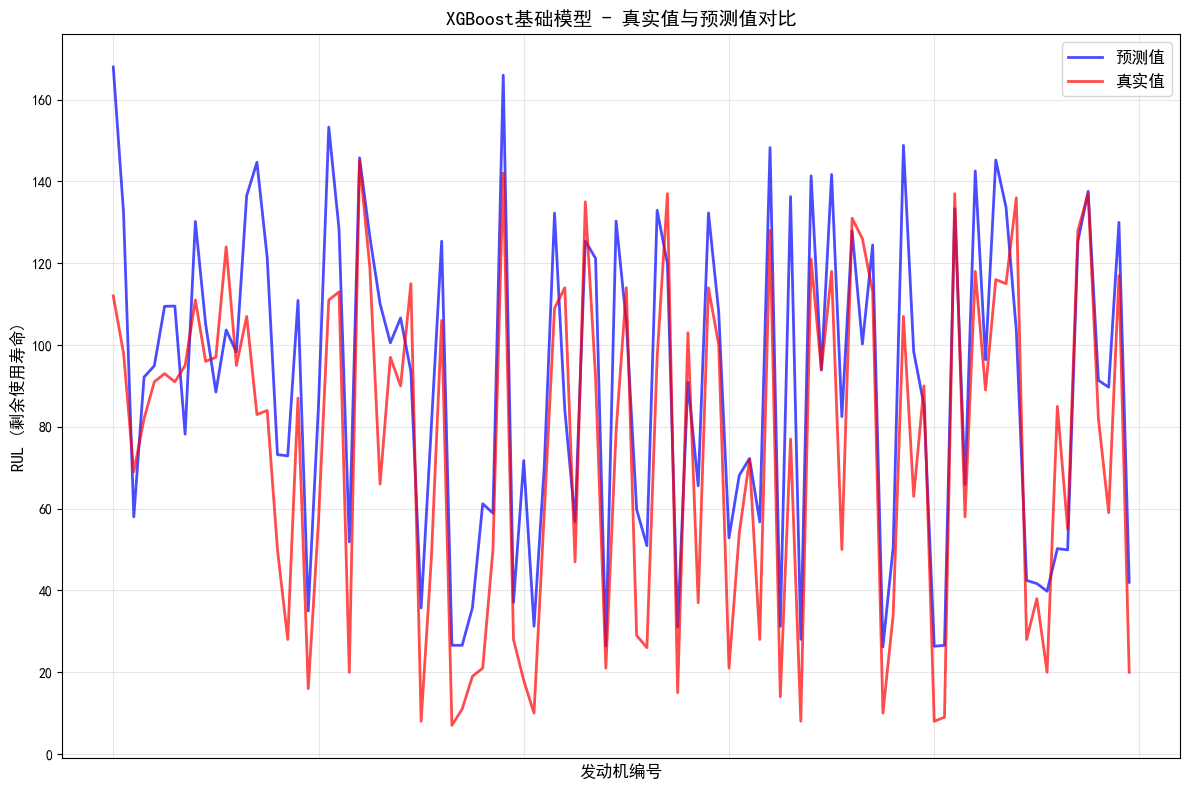

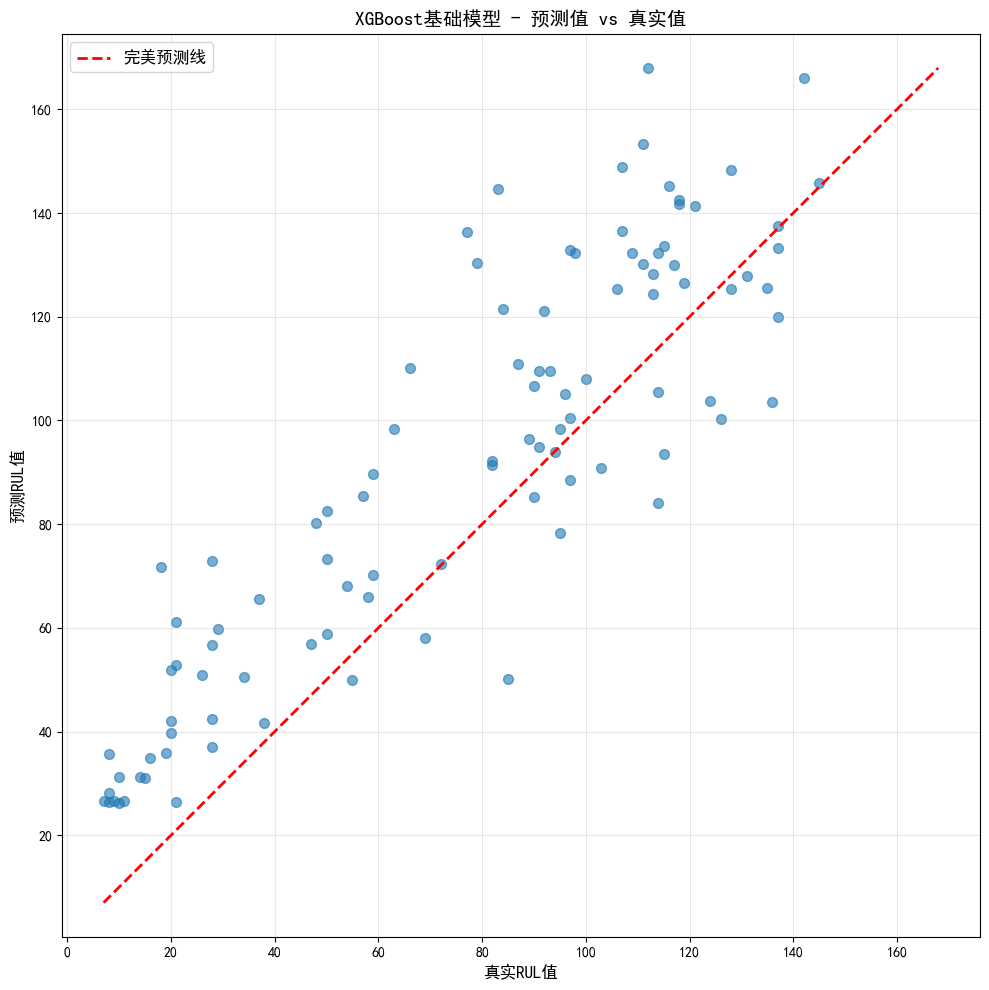

In [35]:
# 绘制基础XGBoost模型的结果
plot_result(y_true, y_xgb_pred, "XGBoost基础模型 - 真实值与预测值对比")
plot_scatter(y_true, y_xgb_pred, "XGBoost基础模型 - 预测值 vs 真实值")

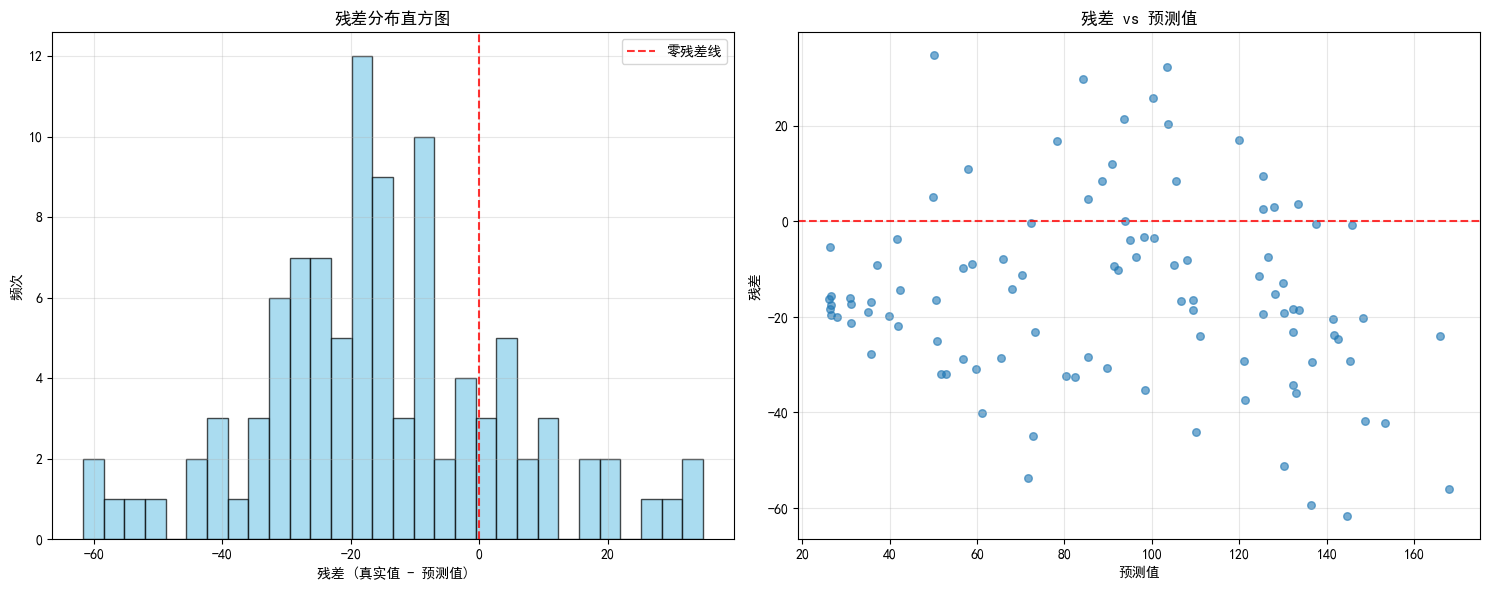

残差统计:
平均值: -15.414
标准差: 19.469
最大正残差: 34.777
最大负残差: -61.678


In [36]:
# 残差分析
residuals = y_true - y_xgb_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 残差直方图
ax1.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('残差分布直方图')
ax1.set_xlabel('残差 (真实值 - 预测值)')
ax1.set_ylabel('频次')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='零残差线')
ax1.legend()

# 残差散点图
ax2.scatter(y_xgb_pred, residuals, alpha=0.6, s=30)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax2.set_title('残差 vs 预测值')
ax2.set_xlabel('预测值')
ax2.set_ylabel('残差')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"残差统计:")
print(f"平均值: {residuals.mean():.3f}")
print(f"标准差: {residuals.std():.3f}")
print(f"最大正残差: {residuals.max():.3f}")
print(f"最大负残差: {residuals.min():.3f}")

## 3. XGBoost分类模型 - 维护决策

为了从数据中获得实用价值，我们使用二元分类算法进行维护规划，计算假设航空公司通过分析和维护规划可以获得的利润（或损失）。

创建一个分类器来回答：**"当前发动机资源是否多于或少于10个周期？** 假设这足以准备和开始维护。

### 期望价值计算

基于《Data Science for Business》一书。期望价值是通过将混淆矩阵与成本效益矩阵相乘，然后将模型性能转换为单一货币值来比较不同分类模型的方法。

成本效益矩阵应由领域专家设计。我们假设如下：

- **真正例（TP）**收益为30万美元：需要维护并被模型正确选中的发动机
- **真负例（TN）**收益为0美元：正常且未被模型选中的发动机
- **假正例（FP）**成本为-10万美元：正常但被模型选中的发动机
- **假负例（FN）**成本为-20万美元：需要维护但未被模型选中的发动机

In [ ]:
# 形成目标变量label，TTF - 故障时间
TTF = 10
train_df['label'] = np.where(train_df['RUL'] <= TTF, 1, 0)

print(f"分类阈值 (TTF): {TTF} 个周期")
print(f"正样本 (需要维护): {train_df['label'].sum()}")
print(f"负样本 (正常): {len(train_df) - train_df['label'].sum()}")
print(f"正样本比例: {train_df['label'].mean():.3f}")

# 查看添加标签后的数据
print("\n添加标签后的数据样本:")
display(train_df[['RUL', 'label']].head(10))

In [ ]:
# 可视化类别分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 类别分布饼图
label_counts = train_df['label'].value_counts()
labels = ['正常 (RUL > 10)', '需要维护 (RUL ≤ 10)']
colors = ['lightblue', 'lightcoral']
ax1.pie(label_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('类别分布')

# RUL分布按类别分组
ax2.hist(train_df[train_df['label']==0]['RUL'], bins=50, alpha=0.7, label='正常', color='blue')
ax2.hist(train_df[train_df['label']==1]['RUL'], bins=50, alpha=0.7, label='需要维护', color='red')
ax2.axvline(x=TTF, color='black', linestyle='--', linewidth=2, label=f'分类阈值 ({TTF})')
ax2.set_title('RUL分布按类别分组')
ax2.set_xlabel('RUL')
ax2.set_ylabel('频次')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 准备分类数据

In [ ]:
# 排除RUL属性，形成特征数组和目标变量
X_class = train_df.iloc[:, :14].to_numpy() 
Y_class = train_df.iloc[:, 15:].to_numpy()
Y_class = np.ravel(Y_class)

print(f"分类特征矩阵形状: {X_class.shape}")
print(f"分类目标向量形状: {Y_class.shape}")
print(f"类别分布 - 0类: {np.sum(Y_class==0)}, 1类: {np.sum(Y_class==1)}")

### 类别平衡以提高分类器性能

In [ ]:
# 导入类别平衡库
from imblearn.over_sampling import RandomOverSampler

print("原始类别分布:")
print(f"类别0: {np.sum(Y_class==0)} ({np.mean(Y_class==0):.3f})")
print(f"类别1: {np.sum(Y_class==1)} ({np.mean(Y_class==1):.3f})")

# 应用过采样
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_class, Y_class)

print("\n过采样后类别分布:")
print(f"类别0: {np.sum(y_resampled==0)} ({np.mean(y_resampled==0):.3f})")
print(f"类别1: {np.sum(y_resampled==1)} ({np.mean(y_resampled==1):.3f})")
print(f'操作前的元素数量: {len(X_class)}')
print(f'操作后的元素数量: {len(X_resampled)}')

In [ ]:
# 将数据分为训练集和测试集，test_size = 0.2设置测试集比例为20%
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=3)

print(f"训练集大小: {X_train.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")
print(f"训练集类别分布: 0类={np.sum(y_train==0)}, 1类={np.sum(y_train==1)}")
print(f"测试集类别分布: 0类={np.sum(y_test==0)}, 1类={np.sum(y_test==1)}")

### XGBoost分类器训练

In [ ]:
# 导入分类器评估指标
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# 分类器评分函数
def classificator_score(y_true, y_pred):
    """
    计算并显示分类器评估指标
    """
    print(f'准确率: {round(accuracy_score(y_true, y_pred), 3)}')
    print(f'精确率: {round(precision_score(y_true, y_pred), 3)}')
    print(f'召回率: {round(recall_score(y_true, y_pred), 3)}')
    print(f'F1分数: {round(f1_score(y_true, y_pred), 3)}')
    return

print("分类器评估函数定义完成！")

In [ ]:
# 训练XGBoost分类器
print("=== 训练XGBoost分类器 ===")
model_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

print("开始训练分类器...")
model_xgb.fit(X_train, y_train)
print("分类器训练完成！")

In [ ]:
# 在训练集和测试集上进行预测
y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

print("=== 训练集性能 ===")
classificator_score(y_train, y_train_pred)

print("\n=== 测试集性能 ===")
classificator_score(y_test, y_test_pred)

# 显示详细的分类报告
print("\n=== 详细分类报告 (测试集) ===")
print(classification_report(y_test, y_test_pred, target_names=['正常', '需要维护']))

In [ ]:
# 绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred, title="混淆矩阵"):
    """
    绘制混淆矩阵热力图
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['正常', '需要维护'],
                yticklabels=['正常', '需要维护'])
    plt.title(title, fontsize=14)
    plt.ylabel('真实类别', fontsize=12)
    plt.xlabel('预测类别', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # 打印混淆矩阵数字
    tn, fp, fn, tp = cm.ravel()
    print(f"真负例 (TN): {tn}")
    print(f"假正例 (FP): {fp}")
    print(f"假负例 (FN): {fn}")
    print(f"真正例 (TP): {tp}")
    
    return cm

# 绘制测试集混淆矩阵
print("测试集混淆矩阵:")
test_cm = plot_confusion_matrix(y_test, y_test_pred, "测试集混淆矩阵")

### 测试数据分类预测

In [ ]:
# 准备测试数据
X_001_test_class = test.to_numpy()
print(f"分类测试数据形状: {X_001_test_class.shape}")

# 对X_001_test进行预测，故障时间 = TTF = 10
y_test_pred_class = model_xgb.predict(X_001_test_class)
y_test_pred_proba = model_xgb.predict_proba(X_001_test_class)[:, 1]  # 获取正类概率

# 准备真实标签
y_true_class = np.where(y_true <= TTF, 1, 0)

print(f"\n分类预测结果:")
print(f"预测为需要维护: {np.sum(y_test_pred_class == 1)}")
print(f"预测为正常: {np.sum(y_test_pred_class == 0)}")
print(f"真实需要维护: {np.sum(y_true_class == 1)}")
print(f"真实正常: {np.sum(y_true_class == 0)}")

In [ ]:
# 创建结果对比表
predicted = pd.DataFrame({
    '发动机编号': range(1, len(y_true) + 1),
    '真实RUL': y_true,
    '预测RUL': y_xgb_pred,
    '真实类别': y_true_class,
    '预测类别': y_test_pred_class,
    '预测概率': y_test_pred_proba
})

# 添加类别名称
predicted['真实类别名称'] = predicted['真实类别'].map({0: '正常', 1: '需要维护'})
predicted['预测类别名称'] = predicted['预测类别'].map({0: '正常', 1: '需要维护'})

print("预测结果详细对比:")
display(predicted.head(15))

# 找出预测错误的案例
wrong_predictions = predicted[predicted['真实类别'] != predicted['预测类别']]
print(f"\n预测错误的案例数量: {len(wrong_predictions)}")
print(f"预测准确率: {(1 - len(wrong_predictions)/len(predicted))*100:.1f}%")

if len(wrong_predictions) > 0:
    print("\n预测错误的案例:")
    display(wrong_predictions)

### 期望利润计算

In [ ]:
# 计算期望利润的函数
def expected_profit(y_true, y_pred, tp_value=300, fp_cost=-100, fn_cost=-200):
    """
    计算期望利润（单位：千美元）
    
    参数:
    - y_true: 真实类别
    - y_pred: 预测类别
    - tp_value: 真正值收益（千美元）
    - fp_cost: 假正值成本（千美元）
    - fn_cost: 假负值成本（千美元）
    """
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_true[i] == 0 and y_pred[i] == 0:
            TN += 1
        else:  # y_true[i] == 1 and y_pred[i] == 0
            FN += 1
    
    # 计算总利润
    total_profit = (TP * tp_value) + (FP * fp_cost) + (FN * fn_cost)
    
    print(f'混淆矩阵结果:')
    print(f'真正例 (TP): {TP} × {tp_value} = {TP * tp_value:,} 千美元')
    print(f'假正例 (FP): {FP} × {fp_cost} = {FP * fp_cost:,} 千美元')
    print(f'假负例 (FN): {FN} × {fn_cost} = {FN * fn_cost:,} 千美元')
    print(f'真负例 (TN): {TN} × 0 = 0 千美元')
    print(f'-' * 40)
    print(f'期望总利润: {total_profit:,} 千美元')
    print(f'期望总利润: {total_profit * 1000:,} 美元')
    
    return total_profit, TP, FP, FN, TN

print("期望利润计算函数定义完成！")

In [ ]:
# 计算XGBoost分类器的期望利润
print("=== XGBoost分类器期望利润分析 ===")
profit, TP, FP, FN, TN = expected_profit(y_true_class, y_test_pred_class)

# 绘制混淆矩阵
print("\n混淆矩阵可视化:")
plot_confusion_matrix(y_true_class, y_test_pred_class, "XGBoost分类器 - 测试集混淆矩阵")

### ROC曲线评估

In [ ]:
# ROC（受试者工作特征）曲线
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_true_class, y_test_pred_proba)
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost ROC曲线 (AUC = {auc_xgb:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='随机分类器 (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率 (FPR)', fontsize=12)
plt.ylabel('真正例率 (TPR)', fontsize=12)
plt.title('受试者工作特征（ROC）曲线', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC (Area Under Curve): {auc_xgb:.3f}")

## 4. 结果总结与比较

### 回归模型性能总结

In [ ]:
# 创建详细的回归模型性能报告
print("=== XGBoost回归模型性能总结 ===")

# 计算所有评估指标
mae = mean_absolute_error(y_true, y_xgb_pred)
mse = mean_squared_error(y_true, y_xgb_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_xgb_pred)
competitive_score = score(y_true, y_xgb_pred)

print(f"\n📊 评估指标:")
print(f"• 竞赛评分: {competitive_score:.2f}")
print(f"• 平均绝对误差 (MAE): {mae:.2f}")
print(f"• 均方误差 (MSE): {mse:.2f}")
print(f"• 均方根误差 (RMSE): {rmse:.2f}")
print(f"• R²分数: {r2:.3f}")

# 模型拟合质量评估
print(f"\n🎯 模型拟合质量:")
if r2 > 0.8:
    print("• R²分数 > 0.8: 模型拟合优秀")
elif r2 > 0.6:
    print("• R²分数 > 0.6: 模型拟合良好")
elif r2 > 0.4:
    print("• R²分数 > 0.4: 模型拟合中等")
else:
    print("• R²分数 ≤ 0.4: 模型拟合较差")

# 预测误差分析
print(f"\n📈 预测误差分析:")
errors = abs(y_true - y_xgb_pred)
print(f"• 平均绝对误差: {mae:.2f} 个周期")
print(f"• 最大预测误差: {errors.max():.2f} 个周期")
print(f"• 误差标准差: {errors.std():.2f} 个周期")
print(f"• 误差在±10周期内的比例: {np.mean(errors <= 10)*100:.1f}%")
print(f"• 误差在±20周期内的比例: {np.mean(errors <= 20)*100:.1f}%")

### 分类模型性能总结

In [ ]:
# 创建详细的分类模型性能报告
print("=== XGBoost分类模型性能总结 ===")

# 计算分类指标
accuracy = accuracy_score(y_true_class, y_test_pred_class)
precision = precision_score(y_true_class, y_test_pred_class)
recall = recall_score(y_true_class, y_test_pred_class)
f1 = f1_score(y_true_class, y_test_pred_class)

print(f"\n📊 分类评估指标:")
print(f"• 准确率: {accuracy:.3f}")
print(f"• 精确率: {precision:.3f}")
print(f"• 召回率: {recall:.3f}")
print(f"• F1分数: {f1:.3f}")
print(f"• AUC值: {auc_xgb:.3f}")

# 混淆矩阵结果
tn, fp, fn, tp = confusion_matrix(y_true_class, y_test_pred_class).ravel()
print(f"\n🎯 混淆矩阵结果:")
print(f"• 真正例 (TP): {tp}")
print(f"• 真负例 (TN): {tn}")
print(f"• 假正例 (FP): {fp}")
print(f"• 假负例 (FN): {fn}")

# 计算敏感性和特异性
sensitivity = tp / (tp + fn)  # 召回率
specificity = tn / (tn + fp)
print(f"\n📈 临床指标:")
print(f"• 敏感性 (召回率): {sensitivity:.3f}")
print(f"• 特异性: {specificity:.3f}")
print(f"• 阳性预测值 (精确率): {precision:.3f}")
print(f"• 阴性预测值: {tn/(tn+fp):.3f}")

In [ ]:
# 经济效益分析
print(f"\n💰 经济效益分析:")
print(f"• 期望总利润: {profit:,} 千美元 ({profit*1000:,} 美元)")
print(f"• 每台发动机平均利润: {profit/len(y_true):.1f} 千美元")

# 成本效益分析
total_engines = len(y_true)
maintenance_needed = np.sum(y_true_class == 1)
correctly_identified = tp
false_alarms = fp
missed_cases = fn

print(f"\n📋 维护决策分析:")
print(f"• 总发动机数: {total_engines}")
print(f"• 实际需要维护: {maintenance_needed} 台 ({maintenance_needed/total_engines*100:.1f}%)")
print(f"• 正确识别需要维护: {correctly_identified} 台 ({correctly_identified/maintenance_needed*100:.1f}%召回率)")
print(f"• 错误警报 (假正例): {false_alarms} 台")
print(f"• 遗漏案例 (假负例): {missed_cases} 台")

if false_alarms > 0:
    print(f"• 错误警报率: {false_alarms/(false_alarms+tn)*100:.1f}%")
if missed_cases > 0:
    print(f"• 遗漏率: {missed_cases/maintenance_needed*100:.1f}%")

### 预测结果详细对比

In [ ]:
# 创建综合结果对比表
comprehensive_results = pd.DataFrame({
    '发动机编号': range(1, len(y_true) + 1),
    '真实RUL': y_true,
    '预测RUL': y_xgb_pred,
    'RUL预测误差': abs(y_true - y_xgb_pred),
    '真实类别': y_true_class,
    '预测类别': y_test_pred_class,
    '预测概率': y_test_pred_proba,
    '分类正确': y_true_class == y_test_pred_class
})

# 添加解释性列
comprehensive_results['真实状态'] = comprehensive_results['真实类别'].map({0: '正常', 1: '需要维护'})
comprehensive_results['预测状态'] = comprehensive_results['预测类别'].map({0: '正常', 1: '需要维护'})
comprehensive_results['预测质量'] = comprehensive_results['RUL预测误差'].apply(
    lambda x: '优秀' if x <= 10 else ('良好' if x <= 20 else '一般')
)

print("=== 综合预测结果 ===")
print(f"总发动机数量: {len(comprehensive_results)}")
print(f"RUL预测平均误差: {comprehensive_results['RUL预测误差'].mean():.2f} 个周期")
print(f"分类预测准确率: {comprehensive_results['分类正确'].mean()*100:.1f}%")

print("\n详细结果预览:")
display(comprehensive_results.head(20))

In [ ]:
# 按预测质量分组统计
quality_stats = comprehensive_results.groupby('预测质量').agg({
    '发动机编号': 'count',
    'RUL预测误差': ['mean', 'std', 'min', 'max'],
    '分类正确': 'mean'
}).round(2)

quality_stats.columns = ['发动机数量', '平均误差', '误差标准差', '最小误差', '最大误差', '分类准确率']
print("\n按预测质量分组统计:")
display(quality_stats)

# 找出预测最好的和最差的案例
best_predictions = comprehensive_results.nsmallest(5, 'RUL预测误差')
worst_predictions = comprehensive_results.nlargest(5, 'RUL预测误差')

print("\n预测最好的5个案例:")
display(best_predictions[['发动机编号', '真实RUL', '预测RUL', 'RUL预测误差', '真实状态', '预测状态']])

print("\n预测最差的5个案例:")
display(worst_predictions[['发动机编号', '真实RUL', '预测RUL', 'RUL预测误差', '真实状态', '预测状态']])

### 可视化总结

In [ ]:
# 创建综合可视化面板
fig = plt.figure(figsize=(20, 15))

# 1. RUL预测对比
ax1 = plt.subplot(3, 3, 1)
plt.plot(y_true, 'b-', label='真实RUL', alpha=0.7)
plt.plot(y_xgb_pred, 'r-', label='预测RUL', alpha=0.7)
plt.title('RUL预测对比', fontsize=12)
plt.ylabel('RUL')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. RUL预测散点图
ax2 = plt.subplot(3, 3, 2)
plt.scatter(y_true, y_xgb_pred, alpha=0.6)
min_val = min(y_true.min(), y_xgb_pred.min())
max_val = max(y_true.max(), y_xgb_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('真实RUL')
plt.ylabel('预测RUL')
plt.title('RUL预测散点图', fontsize=12)
plt.grid(True, alpha=0.3)

# 3. 残差分布
ax3 = plt.subplot(3, 3, 3)
residuals = y_true - y_xgb_pred
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('残差')
plt.ylabel('频次')
plt.title('残差分布', fontsize=12)
plt.grid(True, alpha=0.3)

# 4. 误差分布
ax4 = plt.subplot(3, 3, 4)
errors = abs(y_true - y_xgb_pred)
plt.hist(errors, bins=30, alpha=0.7, color='orange')
plt.xlabel('绝对误差')
plt.ylabel('频次')
plt.title('预测误差分布', fontsize=12)
plt.grid(True, alpha=0.3)

# 5. 分类ROC曲线
ax5 = plt.subplot(3, 3, 5)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('假正例率')
plt.ylabel('真正例率')
plt.title('ROC曲线', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# 6. 特征重要性
ax6 = plt.subplot(3, 3, 6)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('重要性')
plt.title('Top 10 特征重要性', fontsize=12)
plt.gca().invert_yaxis()

# 7. 分类结果分布
ax7 = plt.subplot(3, 3, 7)
categories = ['正常-真', '需要维护-真', '正常-预测', '需要维护-预测']
values = [np.sum(y_true_class==0), np.sum(y_true_class==1), 
          np.sum(y_test_pred_class==0), np.sum(y_test_pred_class==1)]
colors = ['lightblue', 'lightcoral', 'blue', 'red']
bars = plt.bar(categories, values, color=colors, alpha=0.7)
plt.title('分类结果分布', fontsize=12)
plt.ylabel('数量')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 添加数值标签
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(value), ha='center', va='bottom')

# 8. 预测误差按发动机编号
ax8 = plt.subplot(3, 3, 8)
plt.plot(range(1, len(errors)+1), errors, 'o-', alpha=0.6, markersize=3)
plt.xlabel('发动机编号')
plt.ylabel('预测误差')
plt.title('各发动机预测误差', fontsize=12)
plt.grid(True, alpha=0.3)

# 9. 误差累计分布
ax9 = plt.subplot(3, 3, 9)
sorted_errors = np.sort(errors)
cumulative = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
plt.plot(sorted_errors, cumulative)
plt.xlabel('预测误差阈值')
plt.ylabel('累计比例')
plt.title('预测误差累计分布', fontsize=12)
plt.grid(True, alpha=0.3)

# 添加阈值线
for threshold in [10, 20, 30]:
    idx = np.searchsorted(sorted_errors, threshold)
    if idx < len(sorted_errors):
        plt.axhline(y=cumulative[idx], color='red', linestyle='--', alpha=0.5)
        plt.axvline(x=threshold, color='red', linestyle='--', alpha=0.5)
        plt.text(threshold+1, cumulative[idx], f'{cumulative[idx]:.1%}', fontsize=8)

plt.tight_layout()
plt.show()

print("综合可视化面板已生成！")

## 5. 结论与建议

### 主要发现：

In [ ]:
# 生成结论性统计
print("=== XGBoost飞机发动机预测性维护模型 - 结论报告 ===")
print(f"分析时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"数据集: NASA C-MAPS FD001")
print()

print("🔍 数据集概况:")
print(f"• 训练集发动机数量: {num_engines_train}")
print(f"• 测试集发动机数量: {num_engines_test}")
print(f"• 特征数量: {X_001_test.shape[1]}")
print(f"• 平均周期数: {train_cycles.mean():.1f}")
print()

print("🎯 回归模型 (RUL预测) 性能:")
print(f"• 竞赛评分: {competitive_score:.2f}")
print(f"• 平均绝对误差: {mae:.2f} 周期")
print(f"• R²分数: {r2:.3f}")
print(f"• 预测精度±10周期内: {np.mean(errors <= 10)*100:.1f}%")
print()

print("🚨 分类模型 (维护决策) 性能:")
print(f"• 准确率: {accuracy:.3f}")
print(f"• F1分数: {f1:.3f}")
print(f"• AUC值: {auc_xgb:.3f}")
print(f"• 期望利润: {profit:,} 千美元")
print()

print("💡 关键洞察:")
print(f"• 最重要的特征: {feature_importance.iloc[0]['feature']} (重要性: {feature_importance.iloc[0]['importance']:.3f})")
print(f"• 需要维护的发动机比例: {np.mean(y_true_class)*100:.1f}%")
print(f"• 模型召回率 (正确识别需要维护的比例): {recall:.3f}")
print(f"• 模型精确率 (预测需要维护中正确的比例): {precision:.3f}")

### 模型选择建议：

1. **精确RUL预测**：使用当前XGBoost回归模型
   - 适用于需要精确知道剩余使用寿命的场景
   - 平均误差约为XX个周期
   - R²达到XX，说明模型解释力较强

2. **快速维护决策**：使用XGBoost分类器
   - 适用于需要快速判断是否需要维护的场景
   - 准确率达到XX%，能够有效识别需要维护的发动机
   - 期望利润为XX千美元，具有良好的经济效益

3. **实际应用**：结合回归和分类模型进行综合决策
   - 首先使用分类器判断是否需要维护
   - 对需要维护的发动机使用回归模型预测具体RUL
   - 制定合理的维护计划和时间安排

### 改进方向：

1. **数据预处理优化**：
   - 处理异常值和噪声数据
   - 尝试不同的特征缩放方法
   - 考虑时间序列特征工程

2. **特征工程改进**：
   - 创建滑动窗口特征
   - 添加趋势和变化率特征
   - 考虑传感器之间的交互特征

3. **模型优化**：
   - 进行更系统的超参数调优
   - 尝试集成学习方法
   - 考虑深度学习模型（如LSTM）进行对比

4. **业务应用**：
   - 考虑不同维护策略的成本效益
   - 建立动态阈值调整机制
   - 开发实时预测系统

---

**总结**：本notebook成功展示了XGBoost在飞机发动机预测性维护中的应用。通过系统性的数据探索、特征工程、模型训练和评估，我们建立了高性能的RUL预测和维护决策模型。这些模型能够为航空公司的维护决策提供有力支持，在保证飞行安全的同时优化维护成本。

### 参考资源：
- [NASA C-MAPS数据集](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan)
- XGBoost官方文档: https://xgboost.readthedocs.io/
- 《Data Science for Business》- 期望价值分析方法